
## Application: Home Mortgage Disclosure Act Data
---

### Dependent variable

+ deny - Was the mortgage denied?

### Independent variables

+ pirat - Payments to income ratio.
+ hirat - Housing expense to income ratio.
+ lvrat - Loan to value ratio.
+ chist - Credit history: consumer payments.
+ mhist - Credit history: mortgage payments.
+ phist - Public bad credit record?
+ unemp - 1989 Massachusetts unemployment rate in applicant's industry.
+ selfemp - Is the individual self-employed?
+ insurance - Was the individual denied mortgage insurance?
+ condomin - Is the unit a condominium?
+ afam - Is the individual African-American?
+ single - Is the individual single?
+ hschool - Does the individual have a high-school diploma?

### Source

Online complements to Stock and Watson (2007).

### References

+ Munnell, A. H., Tootell, G. M. B., Browne, L. E. and McEneaney, J. (1996). Mortgage Lending in Boston: Interpreting HMDA Data. American Economic Review, 86, 25–53.
+ Stock, J. H. and Watson, M. W. (2007). Introduction to Econometrics, 2nd ed. Boston: Addison Wesley.

https://vincentarelbundock.github.io/Rdatasets/datasets.html


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
from IPython.display import display
pd.set_option('future.no_silent_downcasting', True)

In [2]:
hmda = pd.read_csv('HMDA.csv', index_col=0)
display(hmda)

deny  pirat  hirat     lvrat  chist  mhist phist  unemp selfemp  \
1      no  0.221  0.221  0.800000      5      2    no    3.9      no   
2      no  0.265  0.265  0.921875      2      2    no    3.2      no   
3      no  0.372  0.248  0.920398      1      2    no    3.2      no   
4      no  0.320  0.250  0.860465      1      2    no    4.3      no   
5      no  0.360  0.350  0.600000      1      1    no    3.2      no   
...   ...    ...    ...       ...    ...    ...   ...    ...     ...   
2376   no  0.310  0.250  0.800000      1      1    no    3.2     yes   
2377   no  0.300  0.300  0.777049      1      2    no    3.2      no   
2378   no  0.260  0.200  0.526761      2      1    no    3.1      no   
2379  yes  0.320  0.260  0.753846      6      1   yes    3.1      no   
2380  yes  0.350  0.260  0.813559      2      2    no    4.3      no   

     insurance condomin afam single hschool  
1           no       no   no     no     yes  
2           no       no   no    yes     yes  
3           no       no   no     no     yes  
4           no       no   no     no     yes  
5           no       no   no     no     yes  
...        ...      ...  ...    ...     ...  
2376        no       no   no     no     yes  
2377        no      yes   no    yes     yes  
2378        no       no   no     no     yes  
2379        no      yes  yes    yes     yes  
2380        no      yes   no    yes     yes  

[2380 rows x 14 columns]

In [3]:
dummy_variables = ['deny', 'phist', 'selfemp', 'insurance', 'condomin', 'afam', 'single', 'hschool']
hmda[dummy_variables] = hmda[dummy_variables].replace({'yes':1, 'no':0})
display(hmda)

deny  pirat  hirat     lvrat  chist  mhist phist  unemp selfemp  \
1       0  0.221  0.221  0.800000      5      2     0    3.9       0   
2       0  0.265  0.265  0.921875      2      2     0    3.2       0   
3       0  0.372  0.248  0.920398      1      2     0    3.2       0   
4       0  0.320  0.250  0.860465      1      2     0    4.3       0   
5       0  0.360  0.350  0.600000      1      1     0    3.2       0   
...   ...    ...    ...       ...    ...    ...   ...    ...     ...   
2376    0  0.310  0.250  0.800000      1      1     0    3.2       1   
2377    0  0.300  0.300  0.777049      1      2     0    3.2       0   
2378    0  0.260  0.200  0.526761      2      1     0    3.1       0   
2379    1  0.320  0.260  0.753846      6      1     1    3.1       0   
2380    1  0.350  0.260  0.813559      2      2     0    4.3       0   

     insurance condomin afam single hschool  
1            0        0    0      0       1  
2            0        0    0      1       1  
3            0        0    0      0       1  
4            0        0    0      0       1  
5            0        0    0      0       1  
...        ...      ...  ...    ...     ...  
2376         0        0    0      0       1  
2377         0        1    0      1       1  
2378         0        0    0      0       1  
2379         0        1    1      1       1  
2380         0        1    0      1       1  

[2380 rows x 14 columns]

In [4]:
deny = hmda['deny'].to_numpy(dtype='float64')
features = hmda[hmda.columns[1:]].to_numpy(dtype='float64')
y = deny
X = np.hstack((np.ones((len(deny), 1)), features))
var_names = ['constant', 'pirat', 'hirat', 'lvrat', 'chist', 'mhist', 'phist', 'unemp', 'selfemp', 'insurance', 'condomin', 'afam', 'single', 'hschool']

### Logit model of mortgage denial

\begin{align*}
  \log\frac{p_{i}}{1 - p_{i}} &= \text{constant}
   + \beta_{1}\ \text{pirat}
   + \beta_{2}\ \text{hirat}
   + \beta_{3}\ \text{lvrat}
   + \beta_{4}\ \text{chist}
   + \beta_{5}\ \text{mhist} \\
   &\quad + \beta_{6}\ \text{phist}
   + \beta_{7}\ \text{unemp}
   + \beta_{8}\ \text{selfemp}
   + \beta_{9}\ \text{insurance} \\
   &\quad + \beta_{10}\ \text{condomin}
   + \beta_{11}\ \text{afam}
   + \beta_{12}\ \text{single}
   + \beta_{13}\ \text{hschool},
\end{align*}

where

$$
  p_{i} = \Pr\{\text{Person $i$'s mortgage application is denied.}\}.
$$


In [5]:
k = X.shape[1]
b0, A0 = np.zeros(k), 0.01 * np.eye(k)
logit_model = pm.Model()
with logit_model:
    y_data = pm.Data('y_data', y)
    X_data = pm.Data('X_data', X)
    b = pm.MvNormal('b', mu=b0, tau=A0, shape=k)
    idx = X_data @ b
    likelihood = pm.Bernoulli('y', p=pm.invlogit(idx), observed=y_data)
n_draws, n_chains, n_tune = 5000, 4, 1000
with logit_model:
    # trace_logit = pm.sample(draws=n_draws, chains=n_chains, tune=n_tune, target_accept=0.9, random_seed=123) # PyMC default sampler (very slow)
    trace_logit = pm.sample(draws=n_draws, chains=n_chains, tune=n_tune, target_accept=0.9, random_seed=123, nuts_sampler='numpyro') # numpyro (much faster but does not work on Colab)

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

In [6]:
results_logit = pm.summary(trace_logit, hdi_prob=0.95)
results_logit.index = var_names
sim_param_logit = dict([(var, trace_logit.posterior['b'].to_numpy()[:, :, index]) for index, var in enumerate(var_names)])
display(results_logit)

mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
constant  -6.100  0.698    -7.483     -4.752      0.006    0.005   13975.0   
pirat      4.787  1.022     2.855      6.848      0.008    0.007   17199.0   
hirat     -0.403  1.217    -2.839      1.919      0.009    0.008   19508.0   
lvrat      1.816  0.504     0.817      2.779      0.003    0.004   20903.0   
chist      0.298  0.039     0.224      0.378      0.000    0.000   26918.0   
mhist      0.241  0.143    -0.044      0.514      0.001    0.001   26301.0   
phist      1.244  0.207     0.835      1.646      0.001    0.002   28206.0   
unemp      0.059  0.035    -0.008      0.128      0.000    0.000   27633.0   
selfemp    0.643  0.216     0.229      1.068      0.001    0.002   28044.0   
insurance  4.680  0.584     3.613      5.876      0.004    0.005   26447.0   
condomin  -0.071  0.172    -0.404      0.270      0.001    0.001   26030.0   
afam       0.710  0.179     0.347      1.053      0.001    0.001   26565.0   
single     0.451  0.158     0.146      0.766      0.001    0.001   25093.0   
hschool   -1.070  0.433    -1.896     -0.203      0.003    0.003   18385.0   

           ess_tail  r_hat  
constant    13747.0    1.0  
pirat       15196.0    1.0  
hirat       16109.0    1.0  
lvrat       14732.0    1.0  
chist       14866.0    1.0  
mhist       15114.0    1.0  
phist       15647.0    1.0  
unemp       15382.0    1.0  
selfemp     14886.0    1.0  
insurance   12723.0    1.0  
condomin    15586.0    1.0  
afam        14982.0    1.0  
single      14623.0    1.0  
hschool     14195.0    1.0

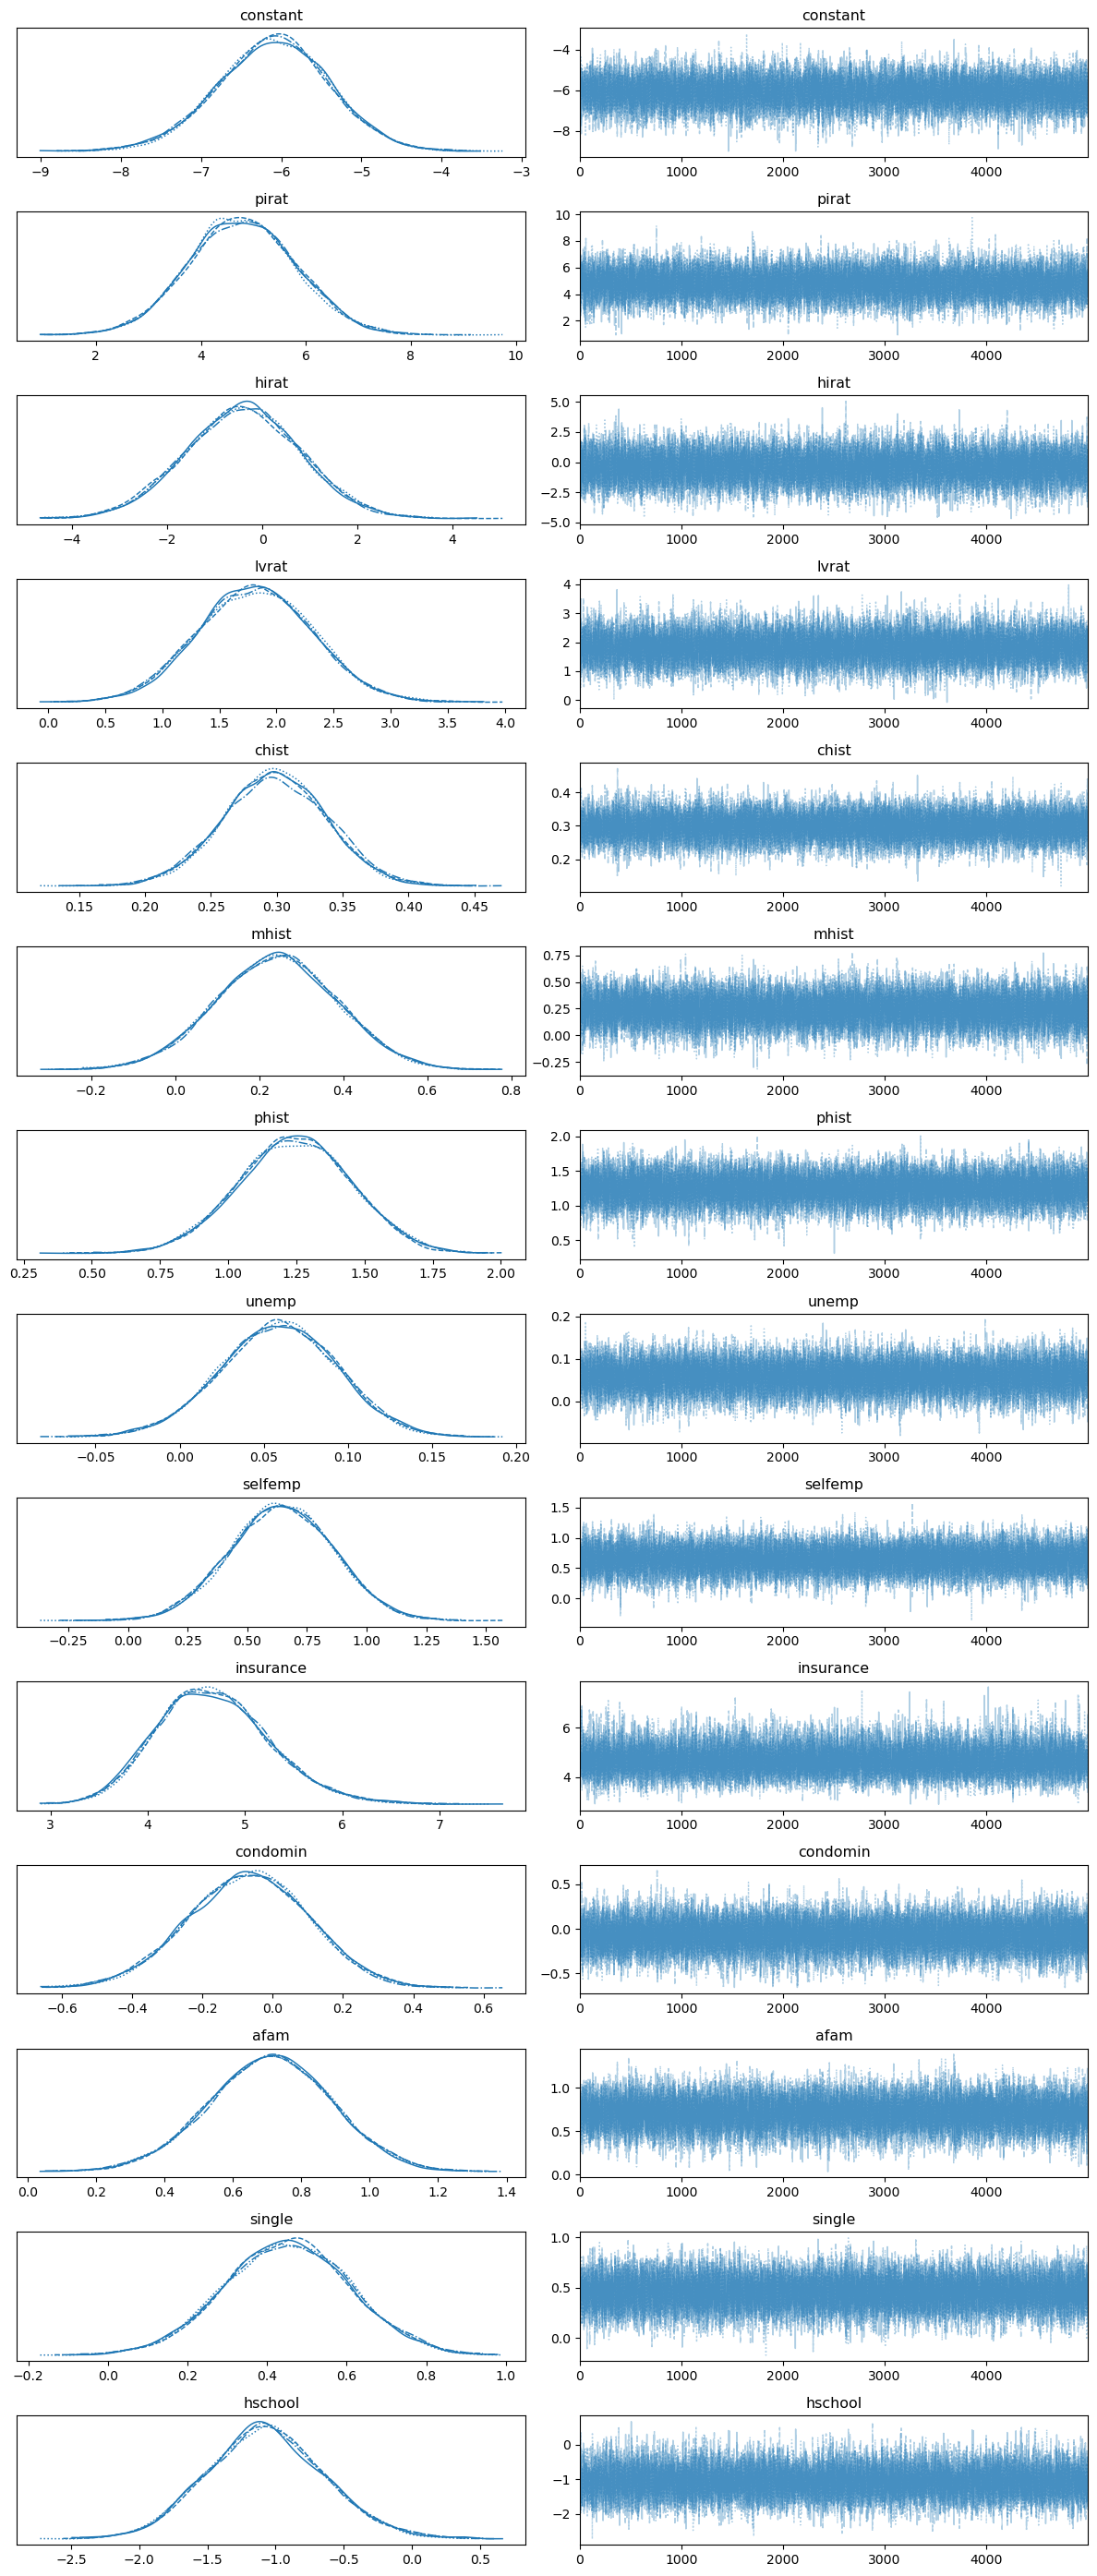

In [7]:
pm.plot_trace(sim_param_logit)
plt.tight_layout()
plt.show()

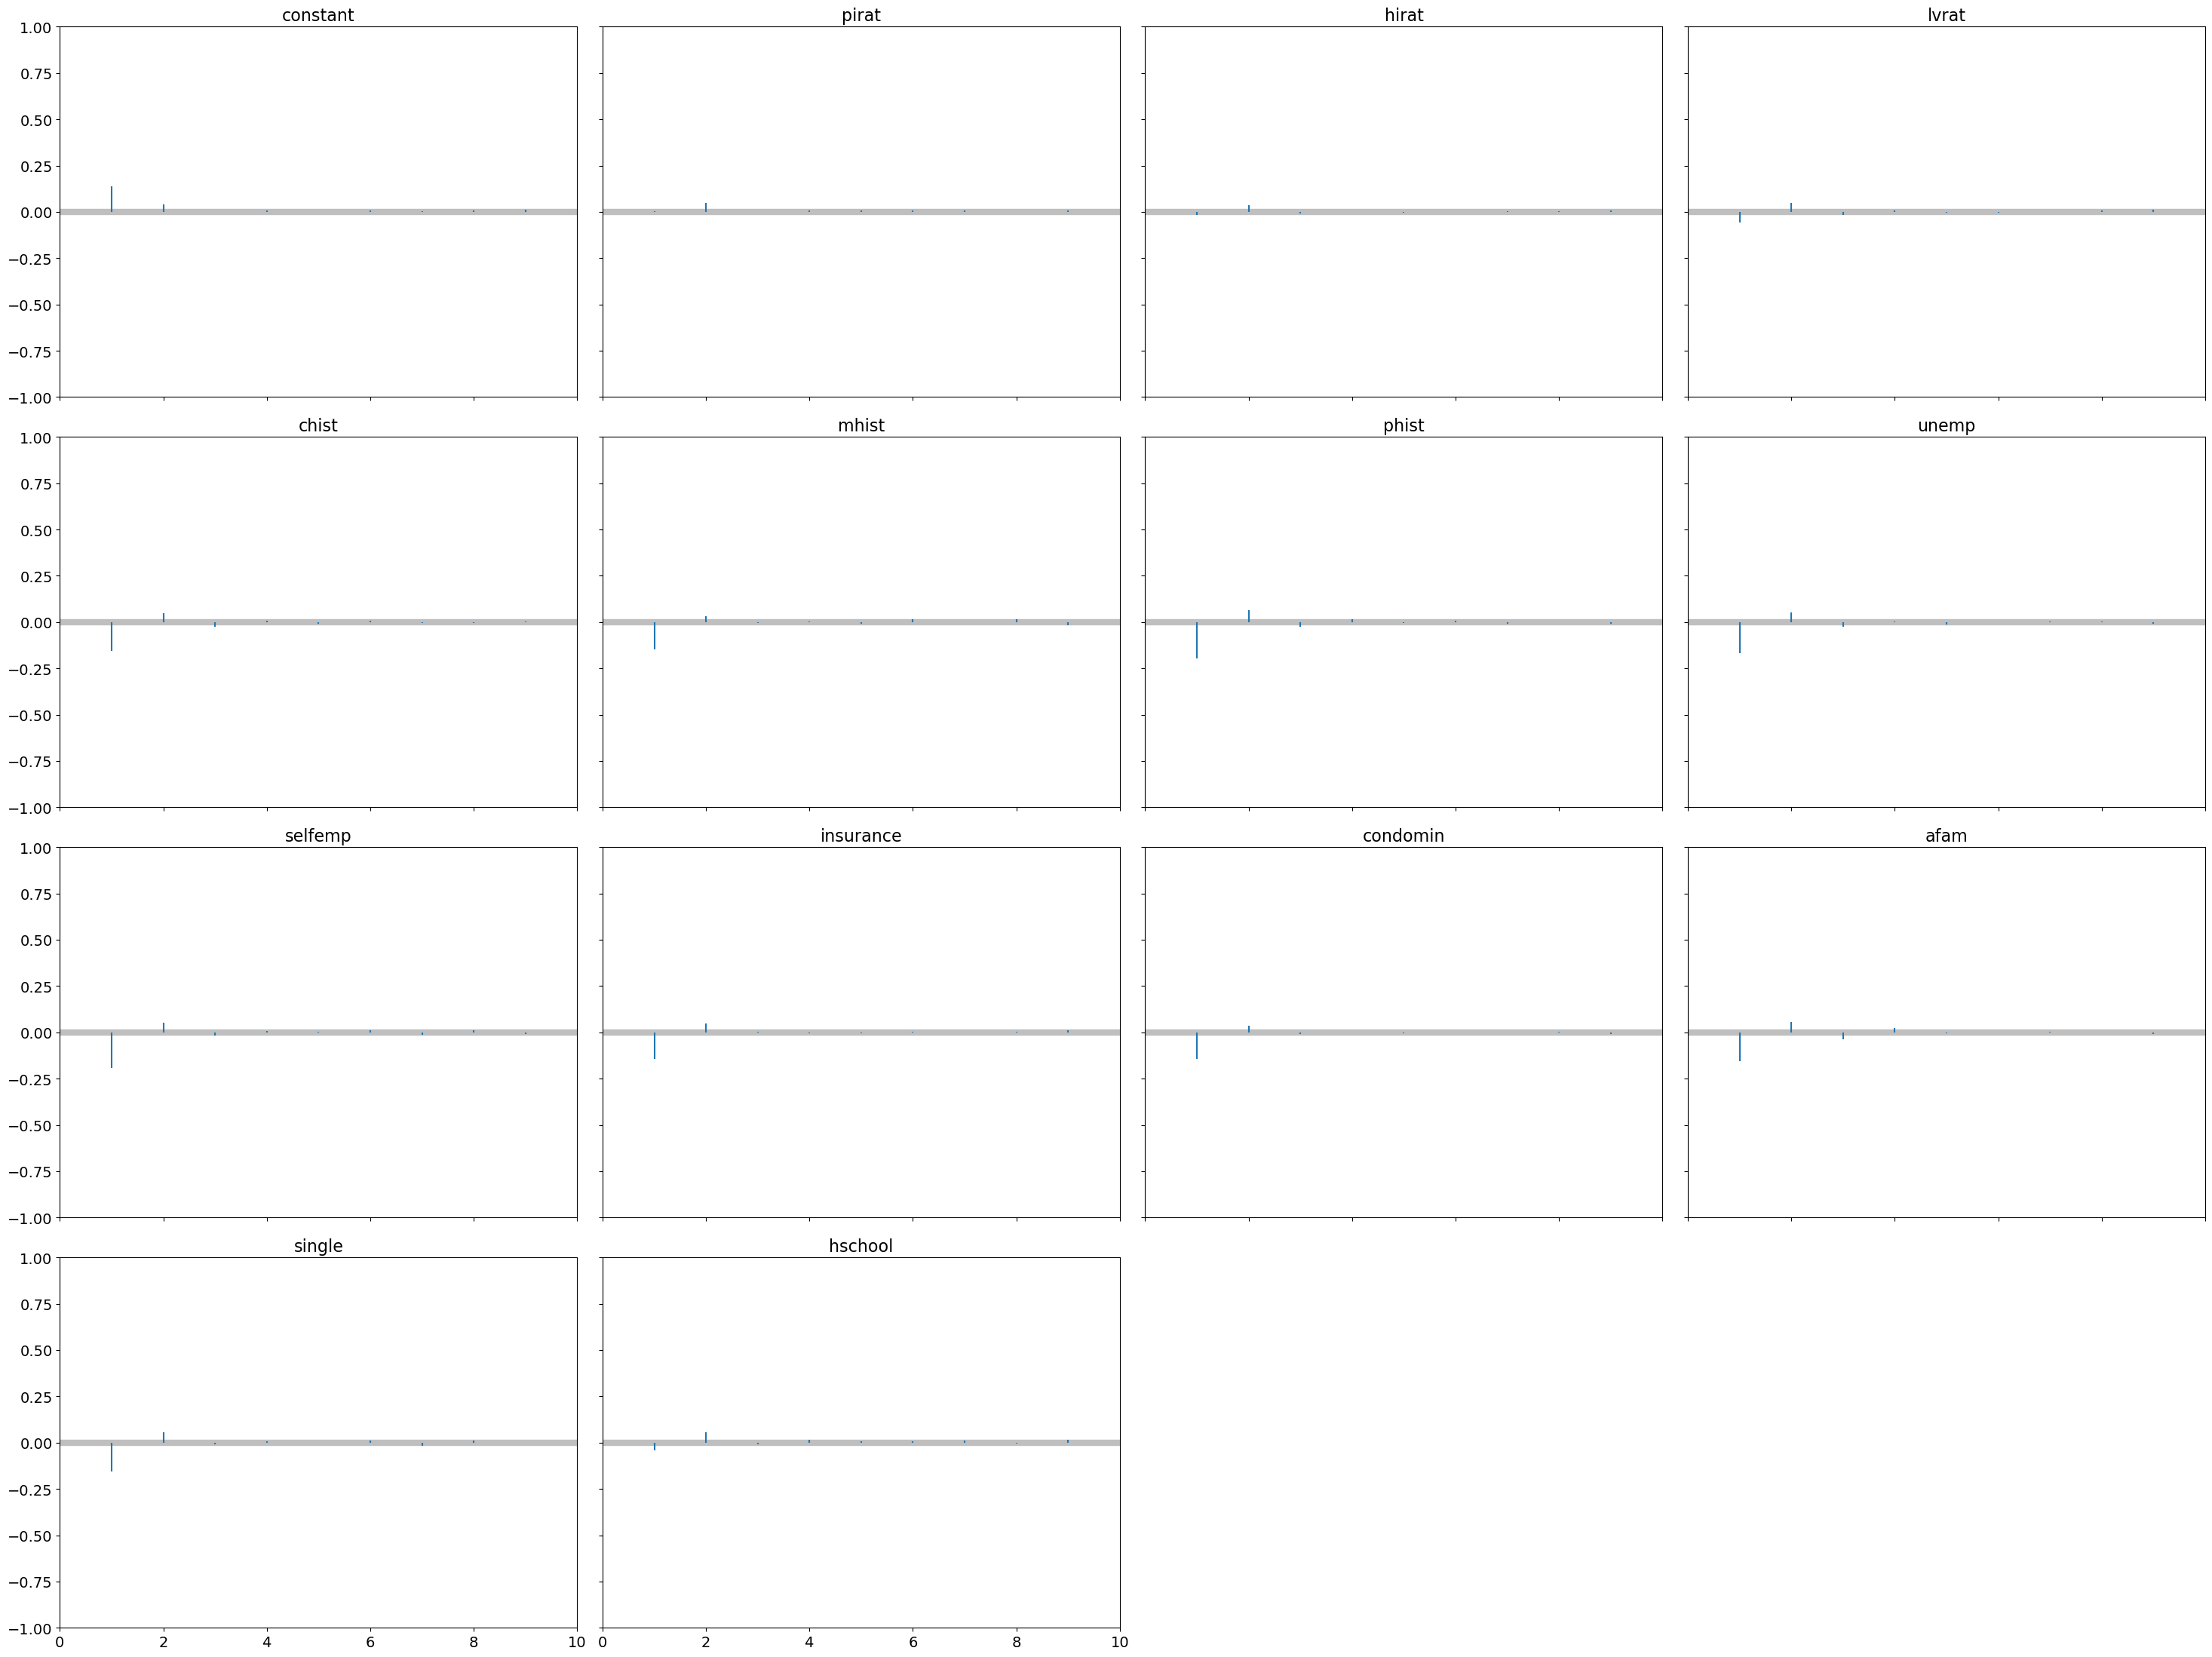

In [8]:
pm.plot_autocorr(sim_param_logit, max_lag=10, combined=True)
plt.tight_layout()
plt.show()

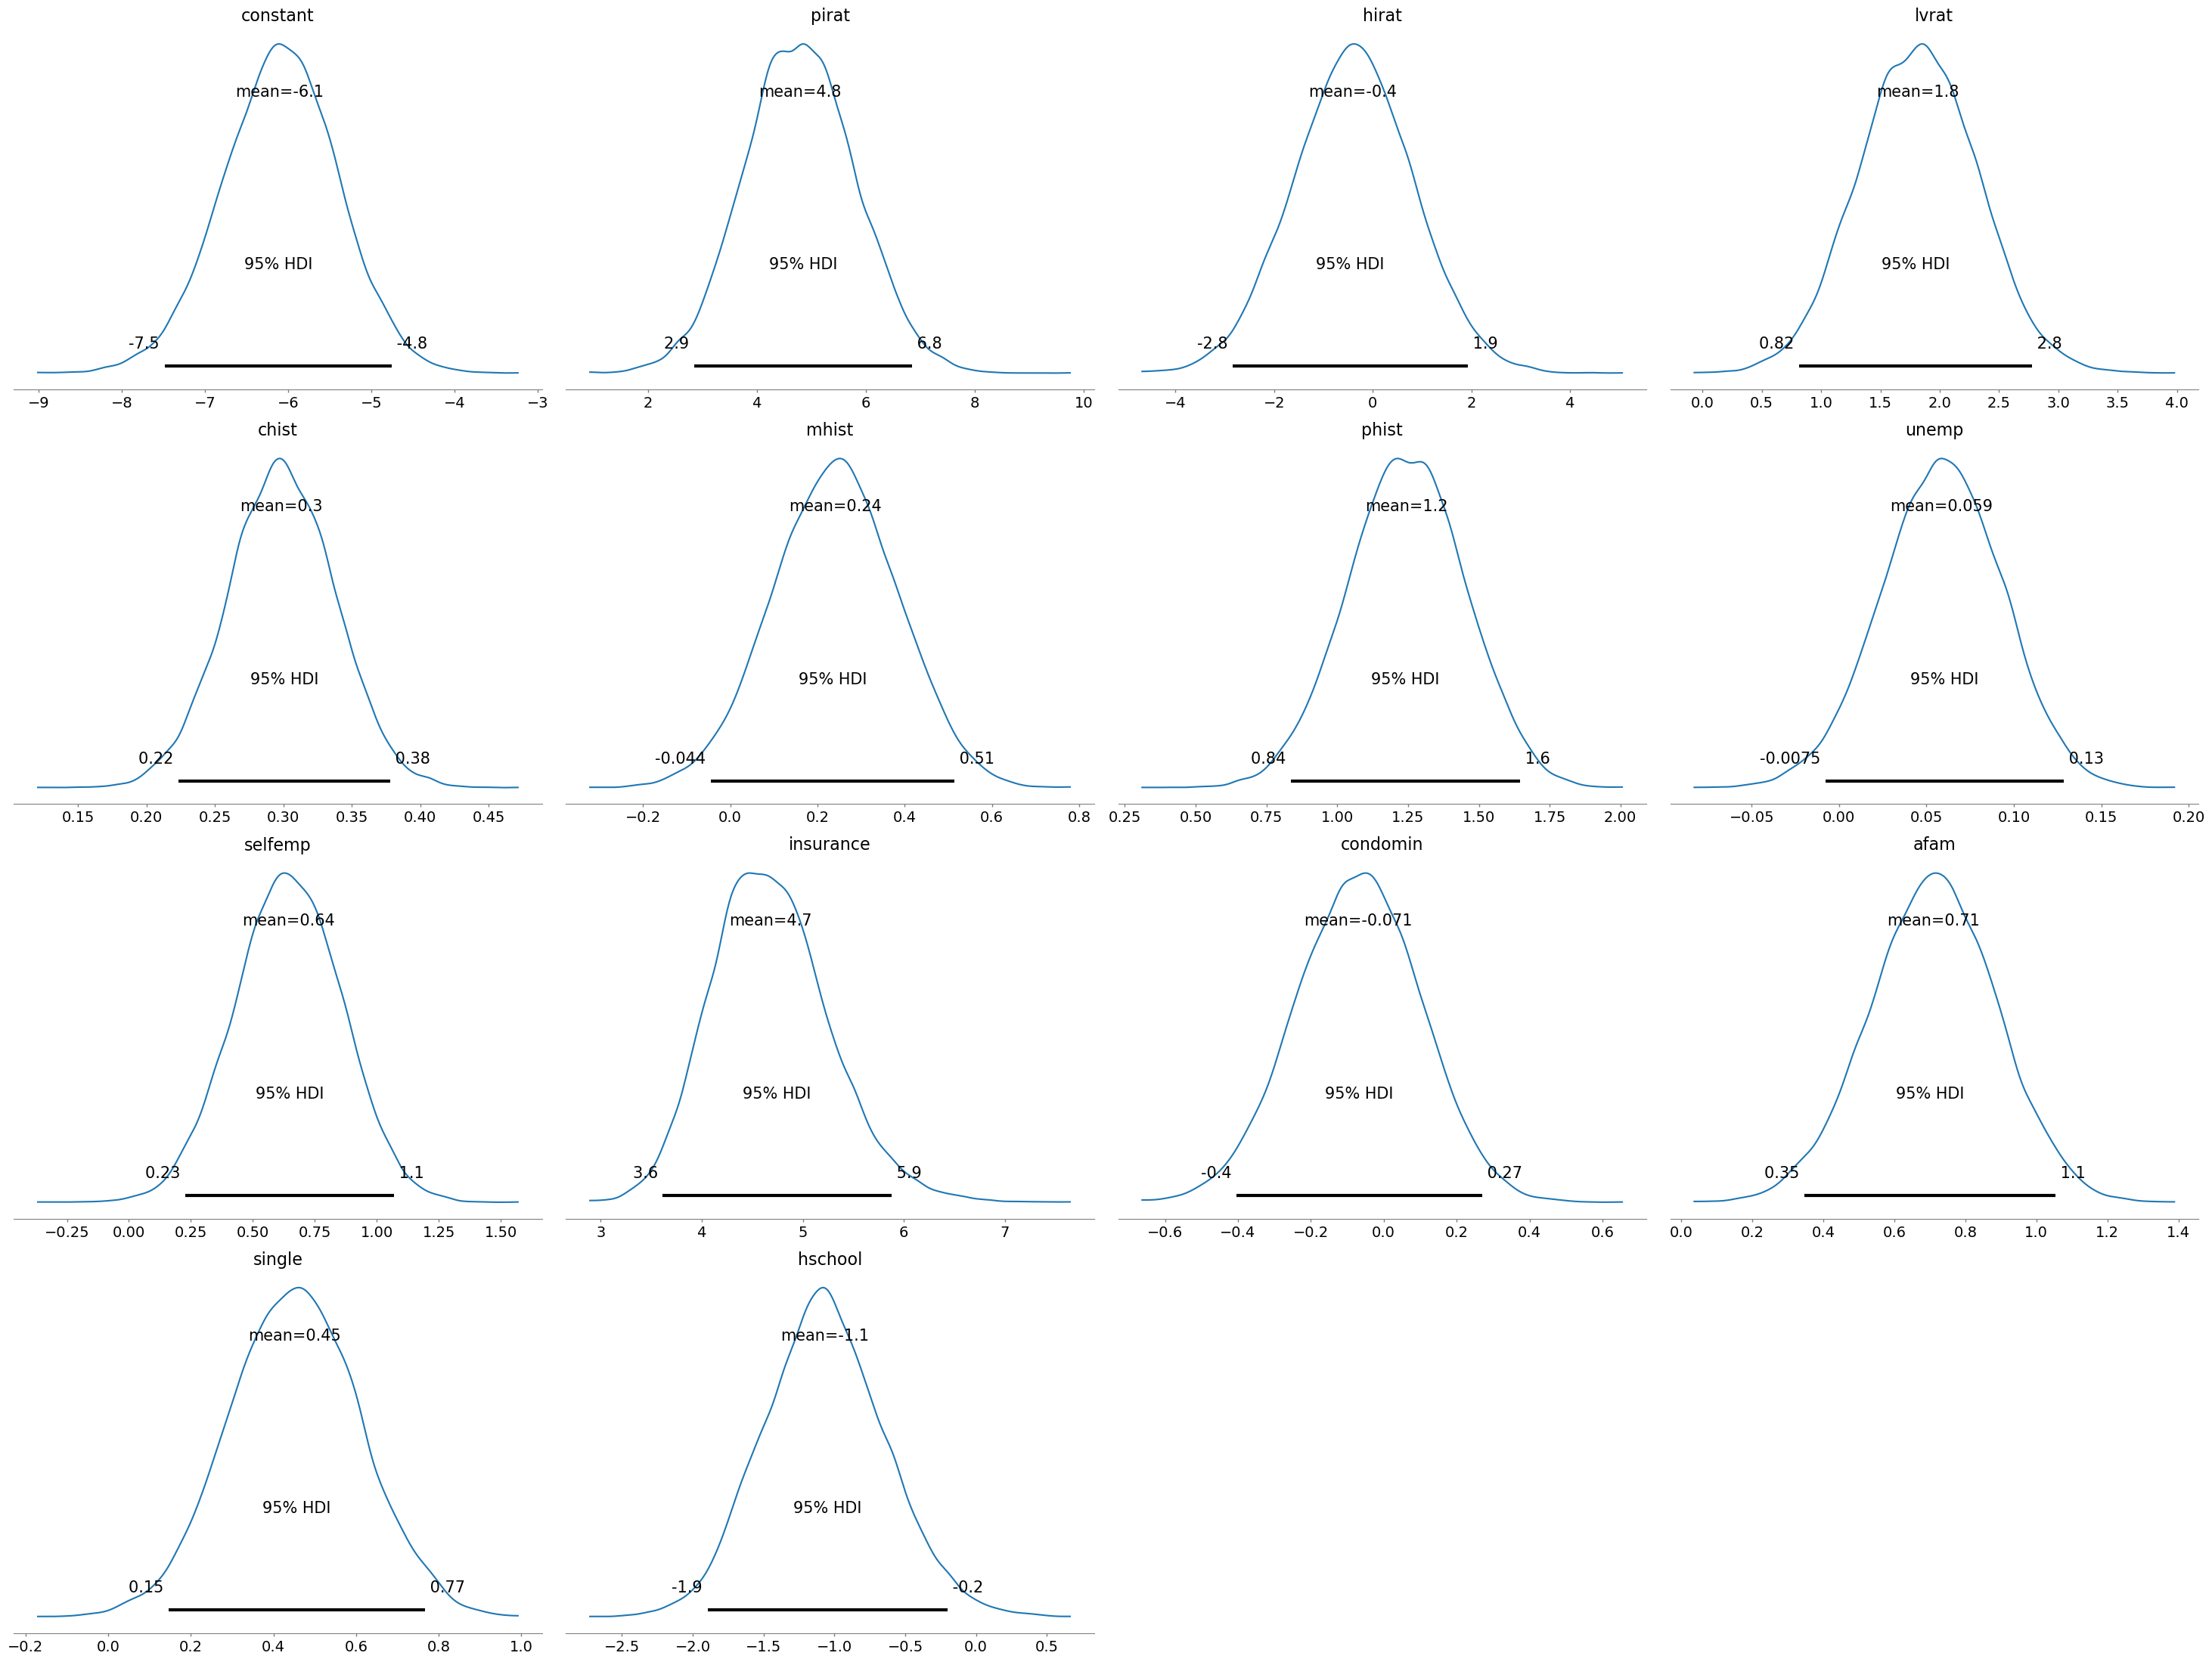

In [9]:
pm.plot_posterior(sim_param_logit, kind='kde', point_estimate='mean', hdi_prob=0.95)
plt.tight_layout()
plt.show()

### Probit model of mortgage denial

\begin{align*}
  p_{i} &= \Pr\{\text{Person $i$'s mortgage application is denied.}\} \\
  &= \Pr\{Z \leqq I_{i}\} = \int_{-\infty}^{I_{i}}\frac{1}{\sqrt{2\pi}}\exp\left(-\frac{z^{2}}{2}\right)dz, \\
  I_{i} &= \text{constant}
   + \beta_{1}\ \text{pirat}
   + \beta_{2}\ \text{hirat}
   + \beta_{3}\ \text{lvrat}
   + \beta_{4}\ \text{chist}
   + \beta_{5}\ \text{mhist} \\
   &\quad + \beta_{6}\ \text{phist}
   + \beta_{7}\ \text{unemp}
   + \beta_{8}\ \text{selfemp}
   + \beta_{9}\ \text{insurance} \\
   &\quad + \beta_{10}\ \text{condomin}
   + \beta_{11}\ \text{afam}
   + \beta_{12}\ \text{single}
   + \beta_{13}\ \text{hschool}.
\end{align*}


In [10]:
probit_model = pm.Model()
with probit_model:
    y_data = pm.Data('y_data', y)
    X_data = pm.Data('X_data', X)
    b = pm.MvNormal('b', mu=b0, tau=A0, shape=k)
    idx = X_data @ b
    likelihood = pm.Bernoulli('y', p=pm.invprobit(idx), observed=y_data)
n_draws, n_chains, n_tune = 5000, 4, 1000
with probit_model:
    # trace_probit = pm.sample(draws=n_draws, chains=n_chains, tune=n_tune, target_accept=0.9, random_seed=123) # PyMC default sampler (very slow)
    trace_probit = pm.sample(draws=n_draws, chains=n_chains, tune=n_tune, target_accept=0.9, random_seed=123, nuts_sampler='numpyro') # numpyro (much faster but does not work on Colab)

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

There were 1029 divergences after tuning. Increase `target_accept` or reparameterize.


In [11]:
results_probit = pm.summary(trace_probit, hdi_prob=0.95)
results_probit.index = var_names
sim_param_probit = dict([(var, trace_probit.posterior['b'].to_numpy()[:, :, index]) for index, var in enumerate(var_names)])
display(results_probit)

mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
constant  -3.121  0.361    -3.843     -2.436      0.003    0.003   13402.0   
pirat      2.505  0.528     1.508      3.569      0.004    0.004   15079.0   
hirat     -0.362  0.637    -1.607      0.889      0.005    0.004   15869.0   
lvrat      0.793  0.244     0.312      1.265      0.002    0.002   18799.0   
chist      0.158  0.021     0.114      0.199      0.000    0.000   22417.0   
mhist      0.123  0.075    -0.024      0.266      0.000    0.001   22326.0   
phist      0.711  0.119     0.474      0.940      0.001    0.001   24124.0   
unemp      0.031  0.018    -0.006      0.066      0.000    0.000   25873.0   
selfemp    0.339  0.114     0.114      0.557      0.001    0.001   23599.0   
insurance  2.604  0.290     2.036      3.165      0.002    0.002   23643.0   
condomin  -0.031  0.090    -0.205      0.144      0.001    0.001   23023.0   
afam       0.397  0.097     0.211      0.596      0.001    0.001   24380.0   
single     0.248  0.082     0.085      0.405      0.001    0.001   23017.0   
hschool   -0.576  0.242    -1.051     -0.107      0.002    0.002   17140.0   

           ess_tail  r_hat  
constant    12776.0    1.0  
pirat       13519.0    1.0  
hirat       13951.0    1.0  
lvrat       14387.0    1.0  
chist       13041.0    1.0  
mhist       14268.0    1.0  
phist       14960.0    1.0  
unemp       14984.0    1.0  
selfemp     13214.0    1.0  
insurance   12402.0    1.0  
condomin    13859.0    1.0  
afam        14577.0    1.0  
single      14488.0    1.0  
hschool     14653.0    1.0

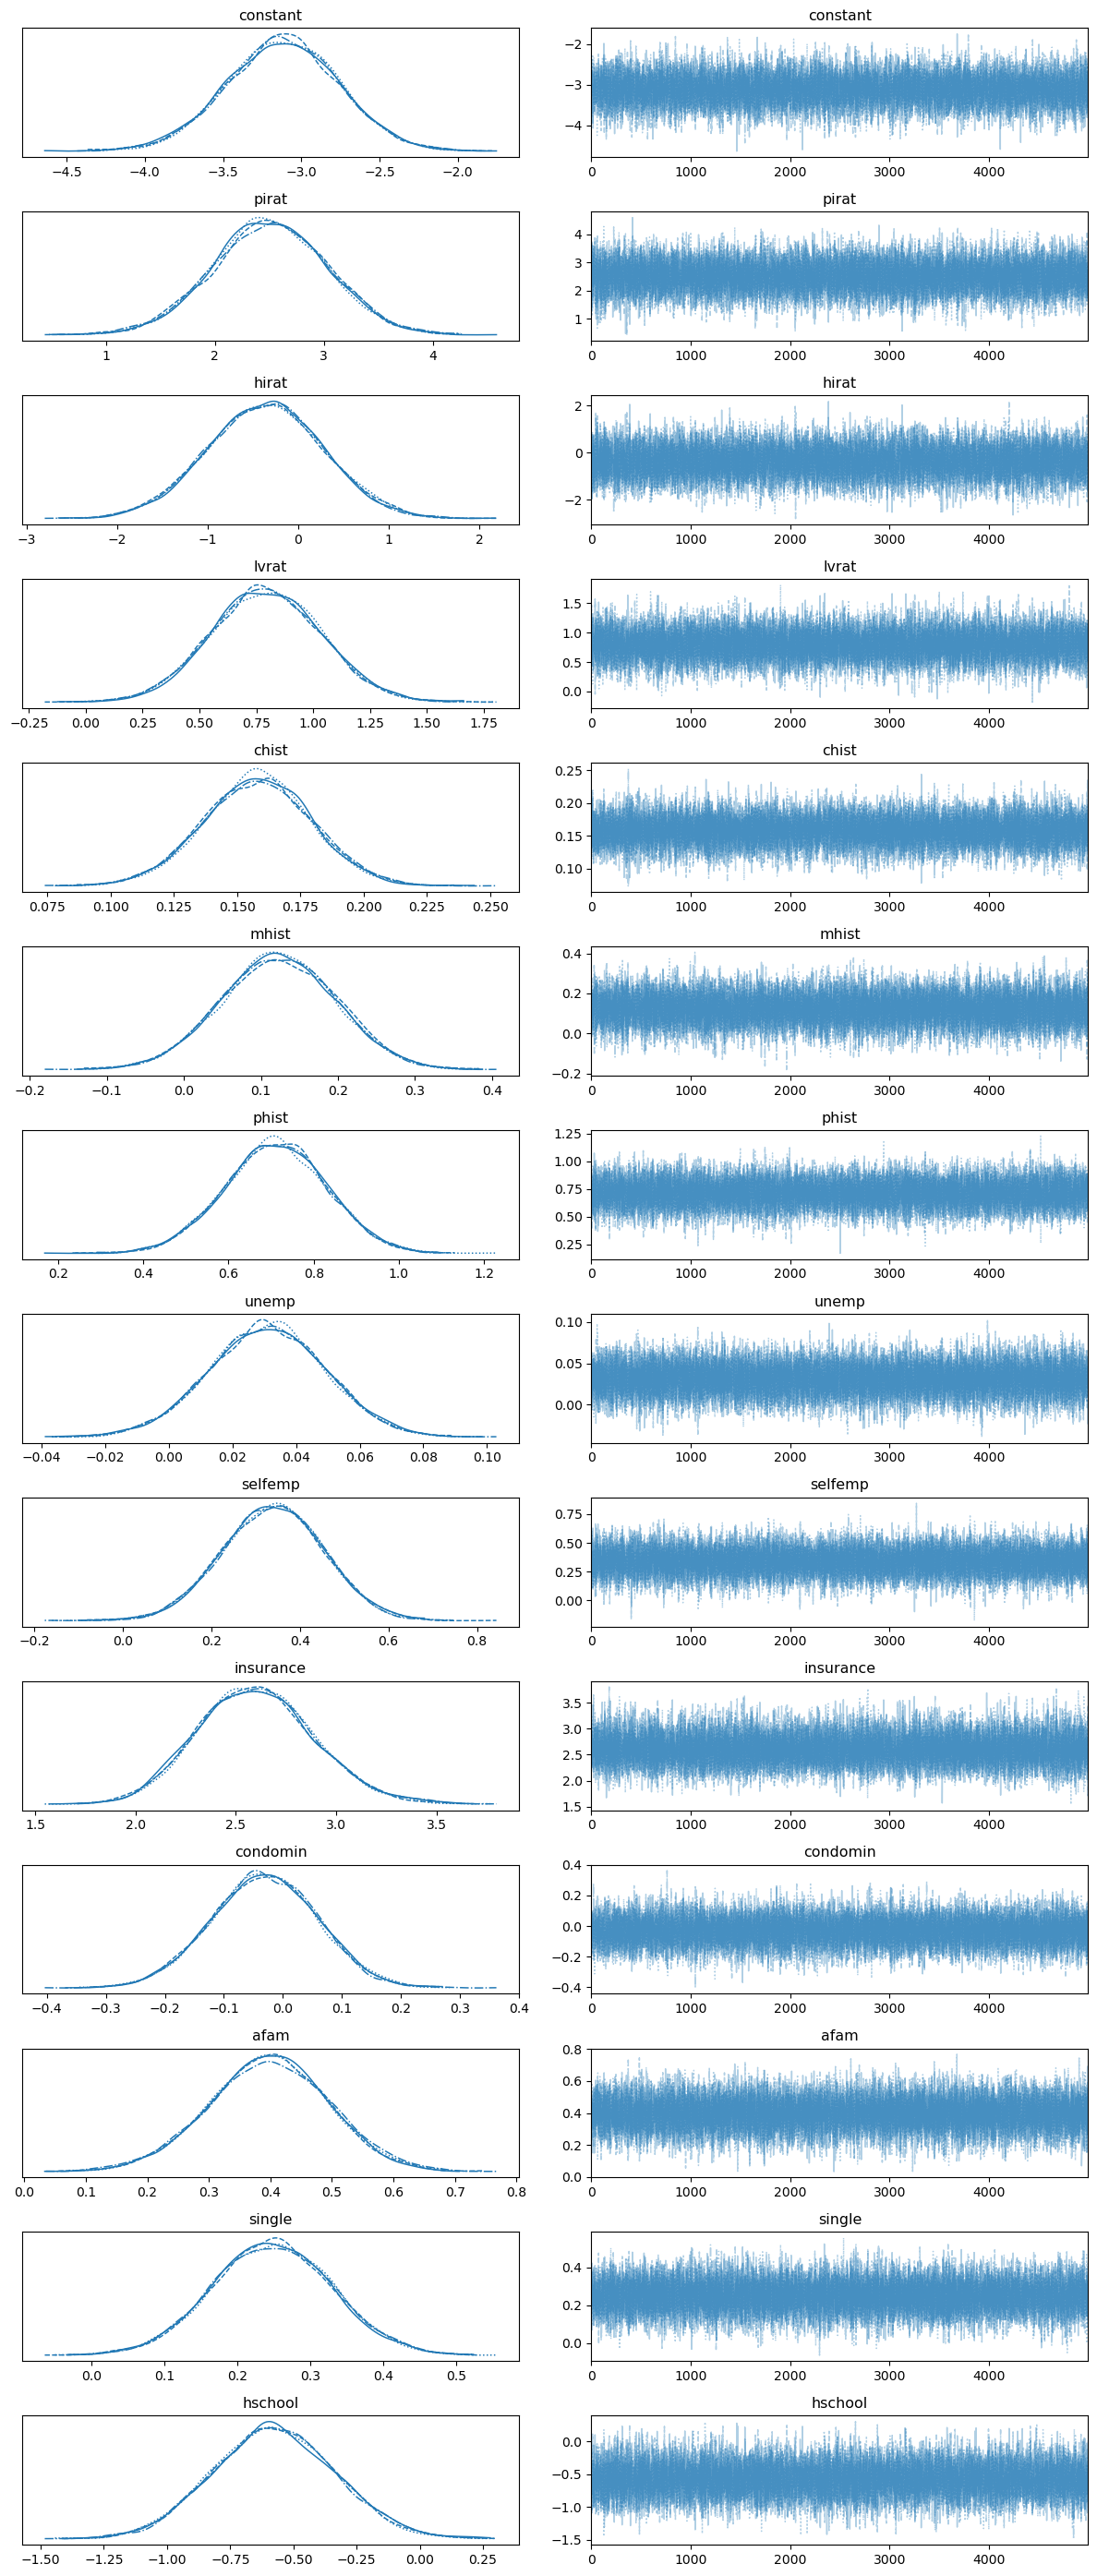

In [12]:
pm.plot_trace(sim_param_probit)
plt.tight_layout()
plt.show()

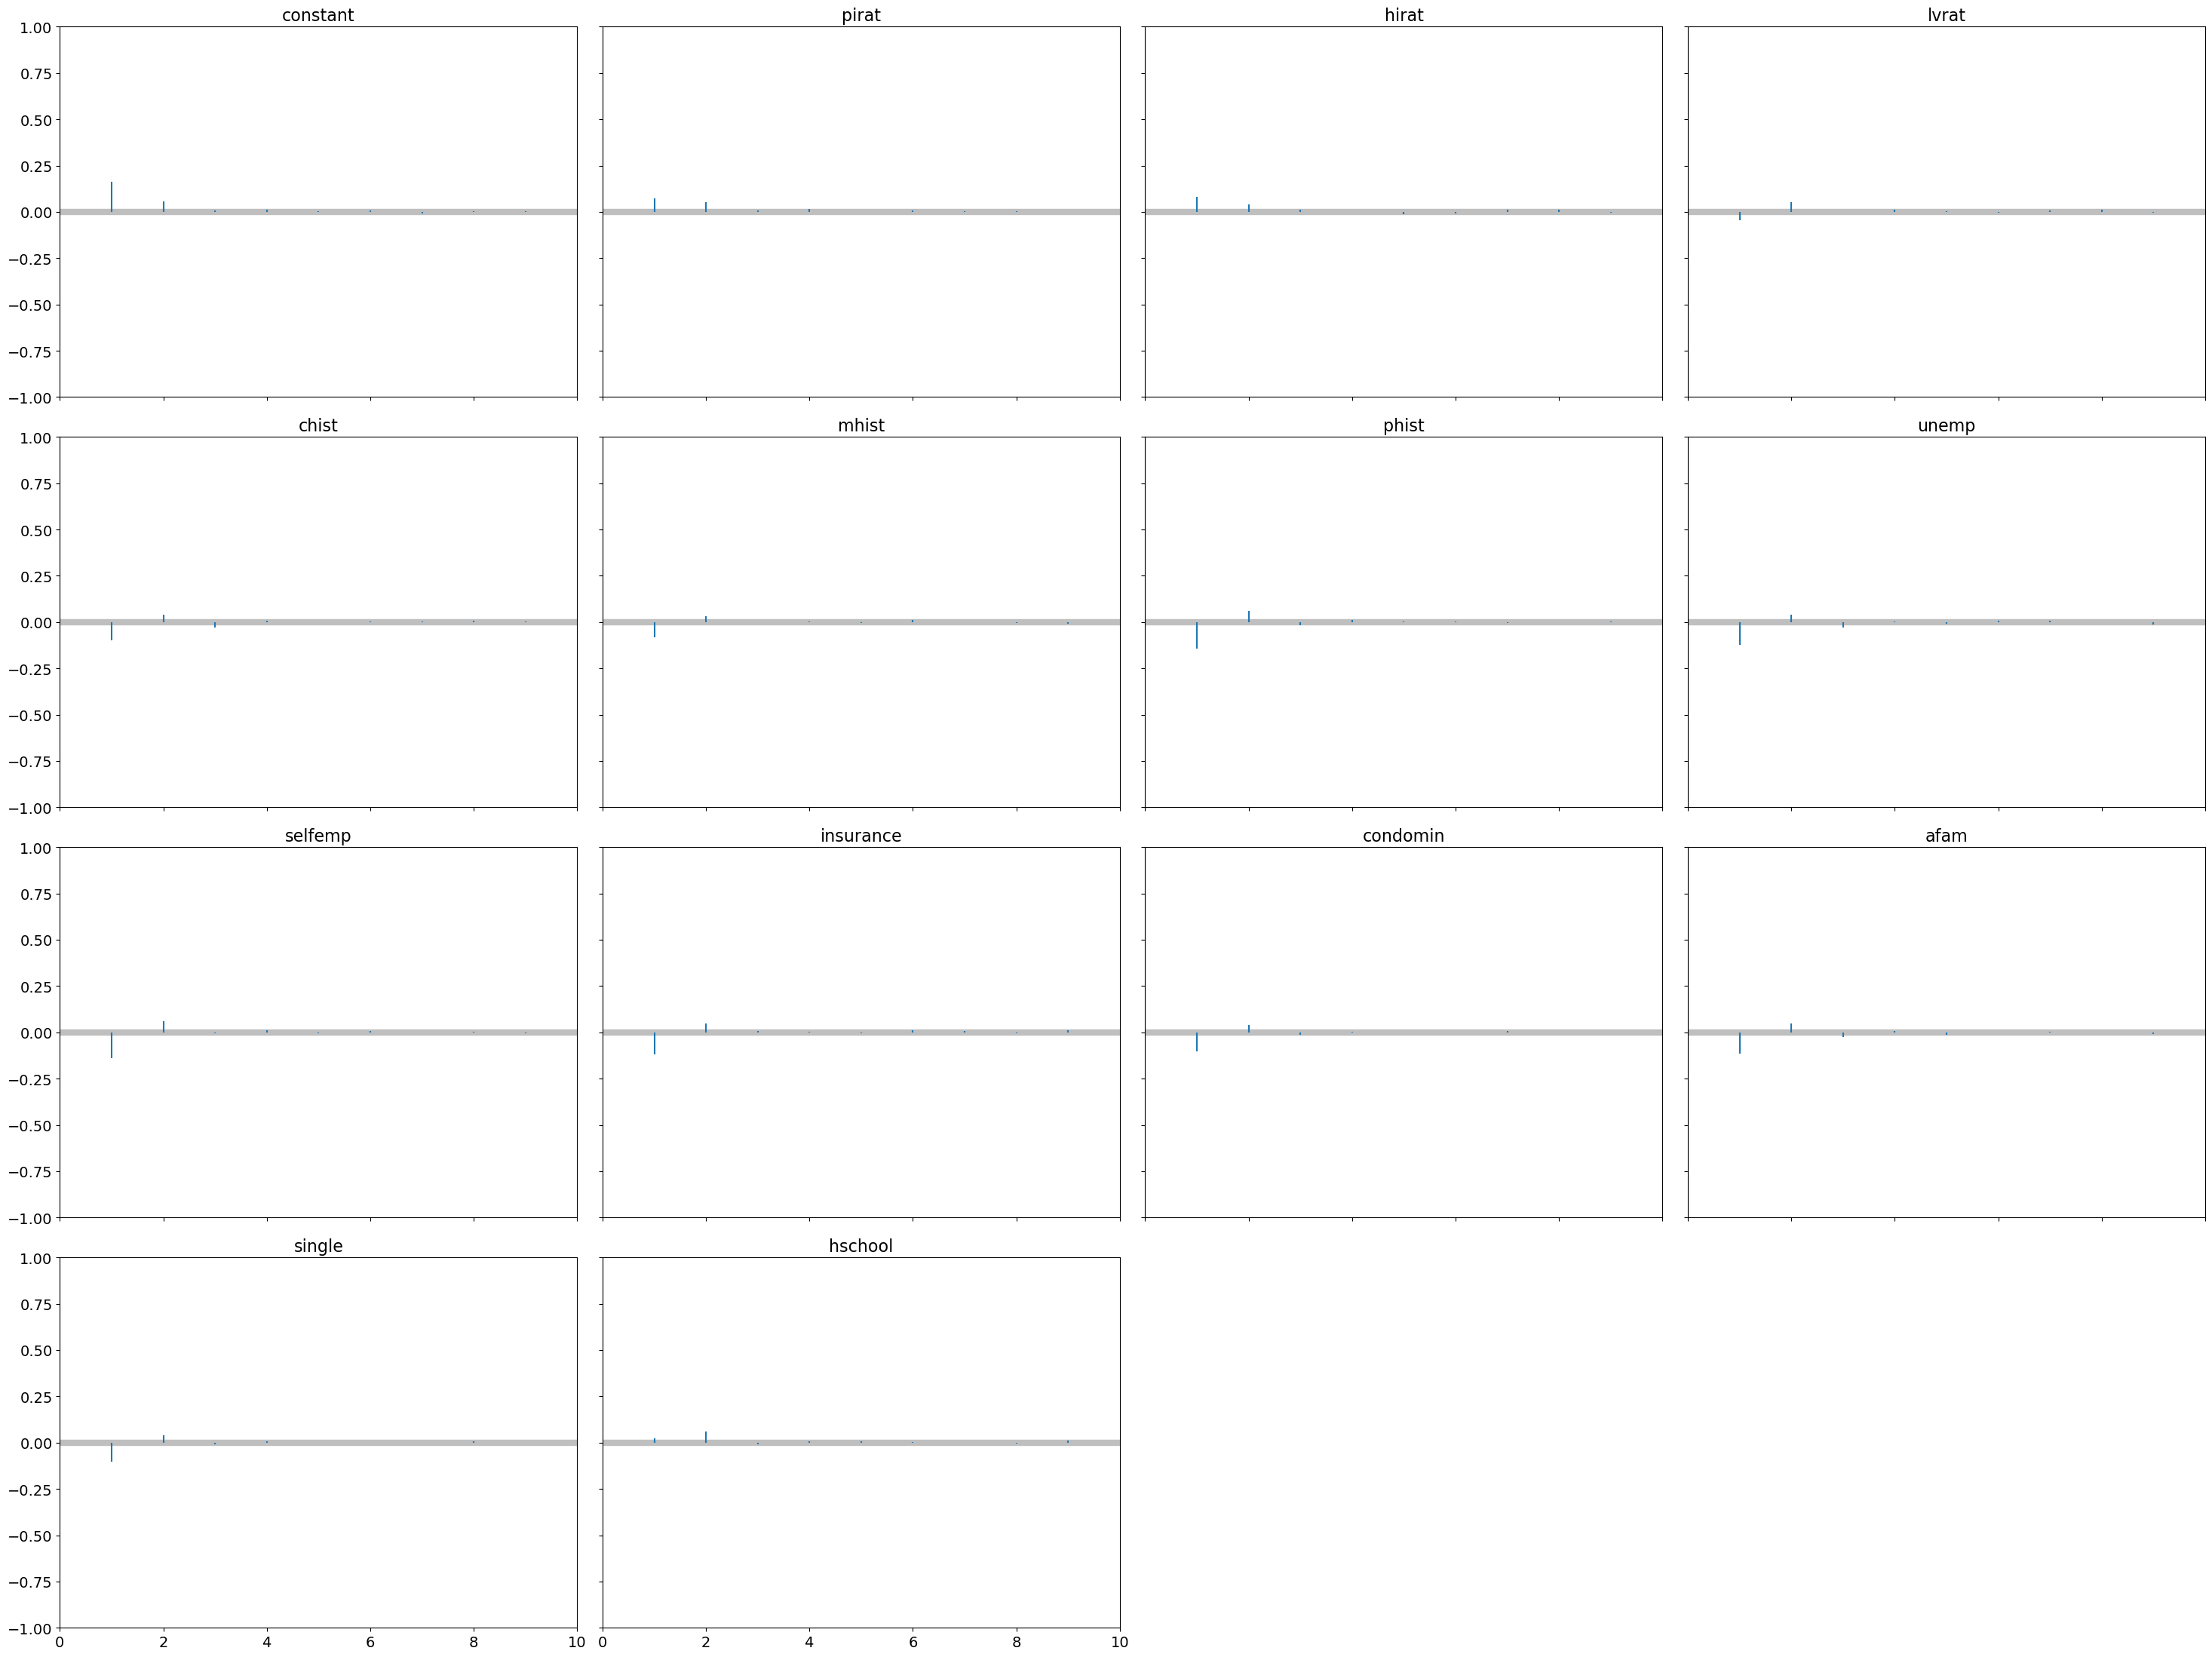

In [13]:
pm.plot_autocorr(sim_param_probit, max_lag=10, combined=True)
plt.tight_layout()
plt.show()

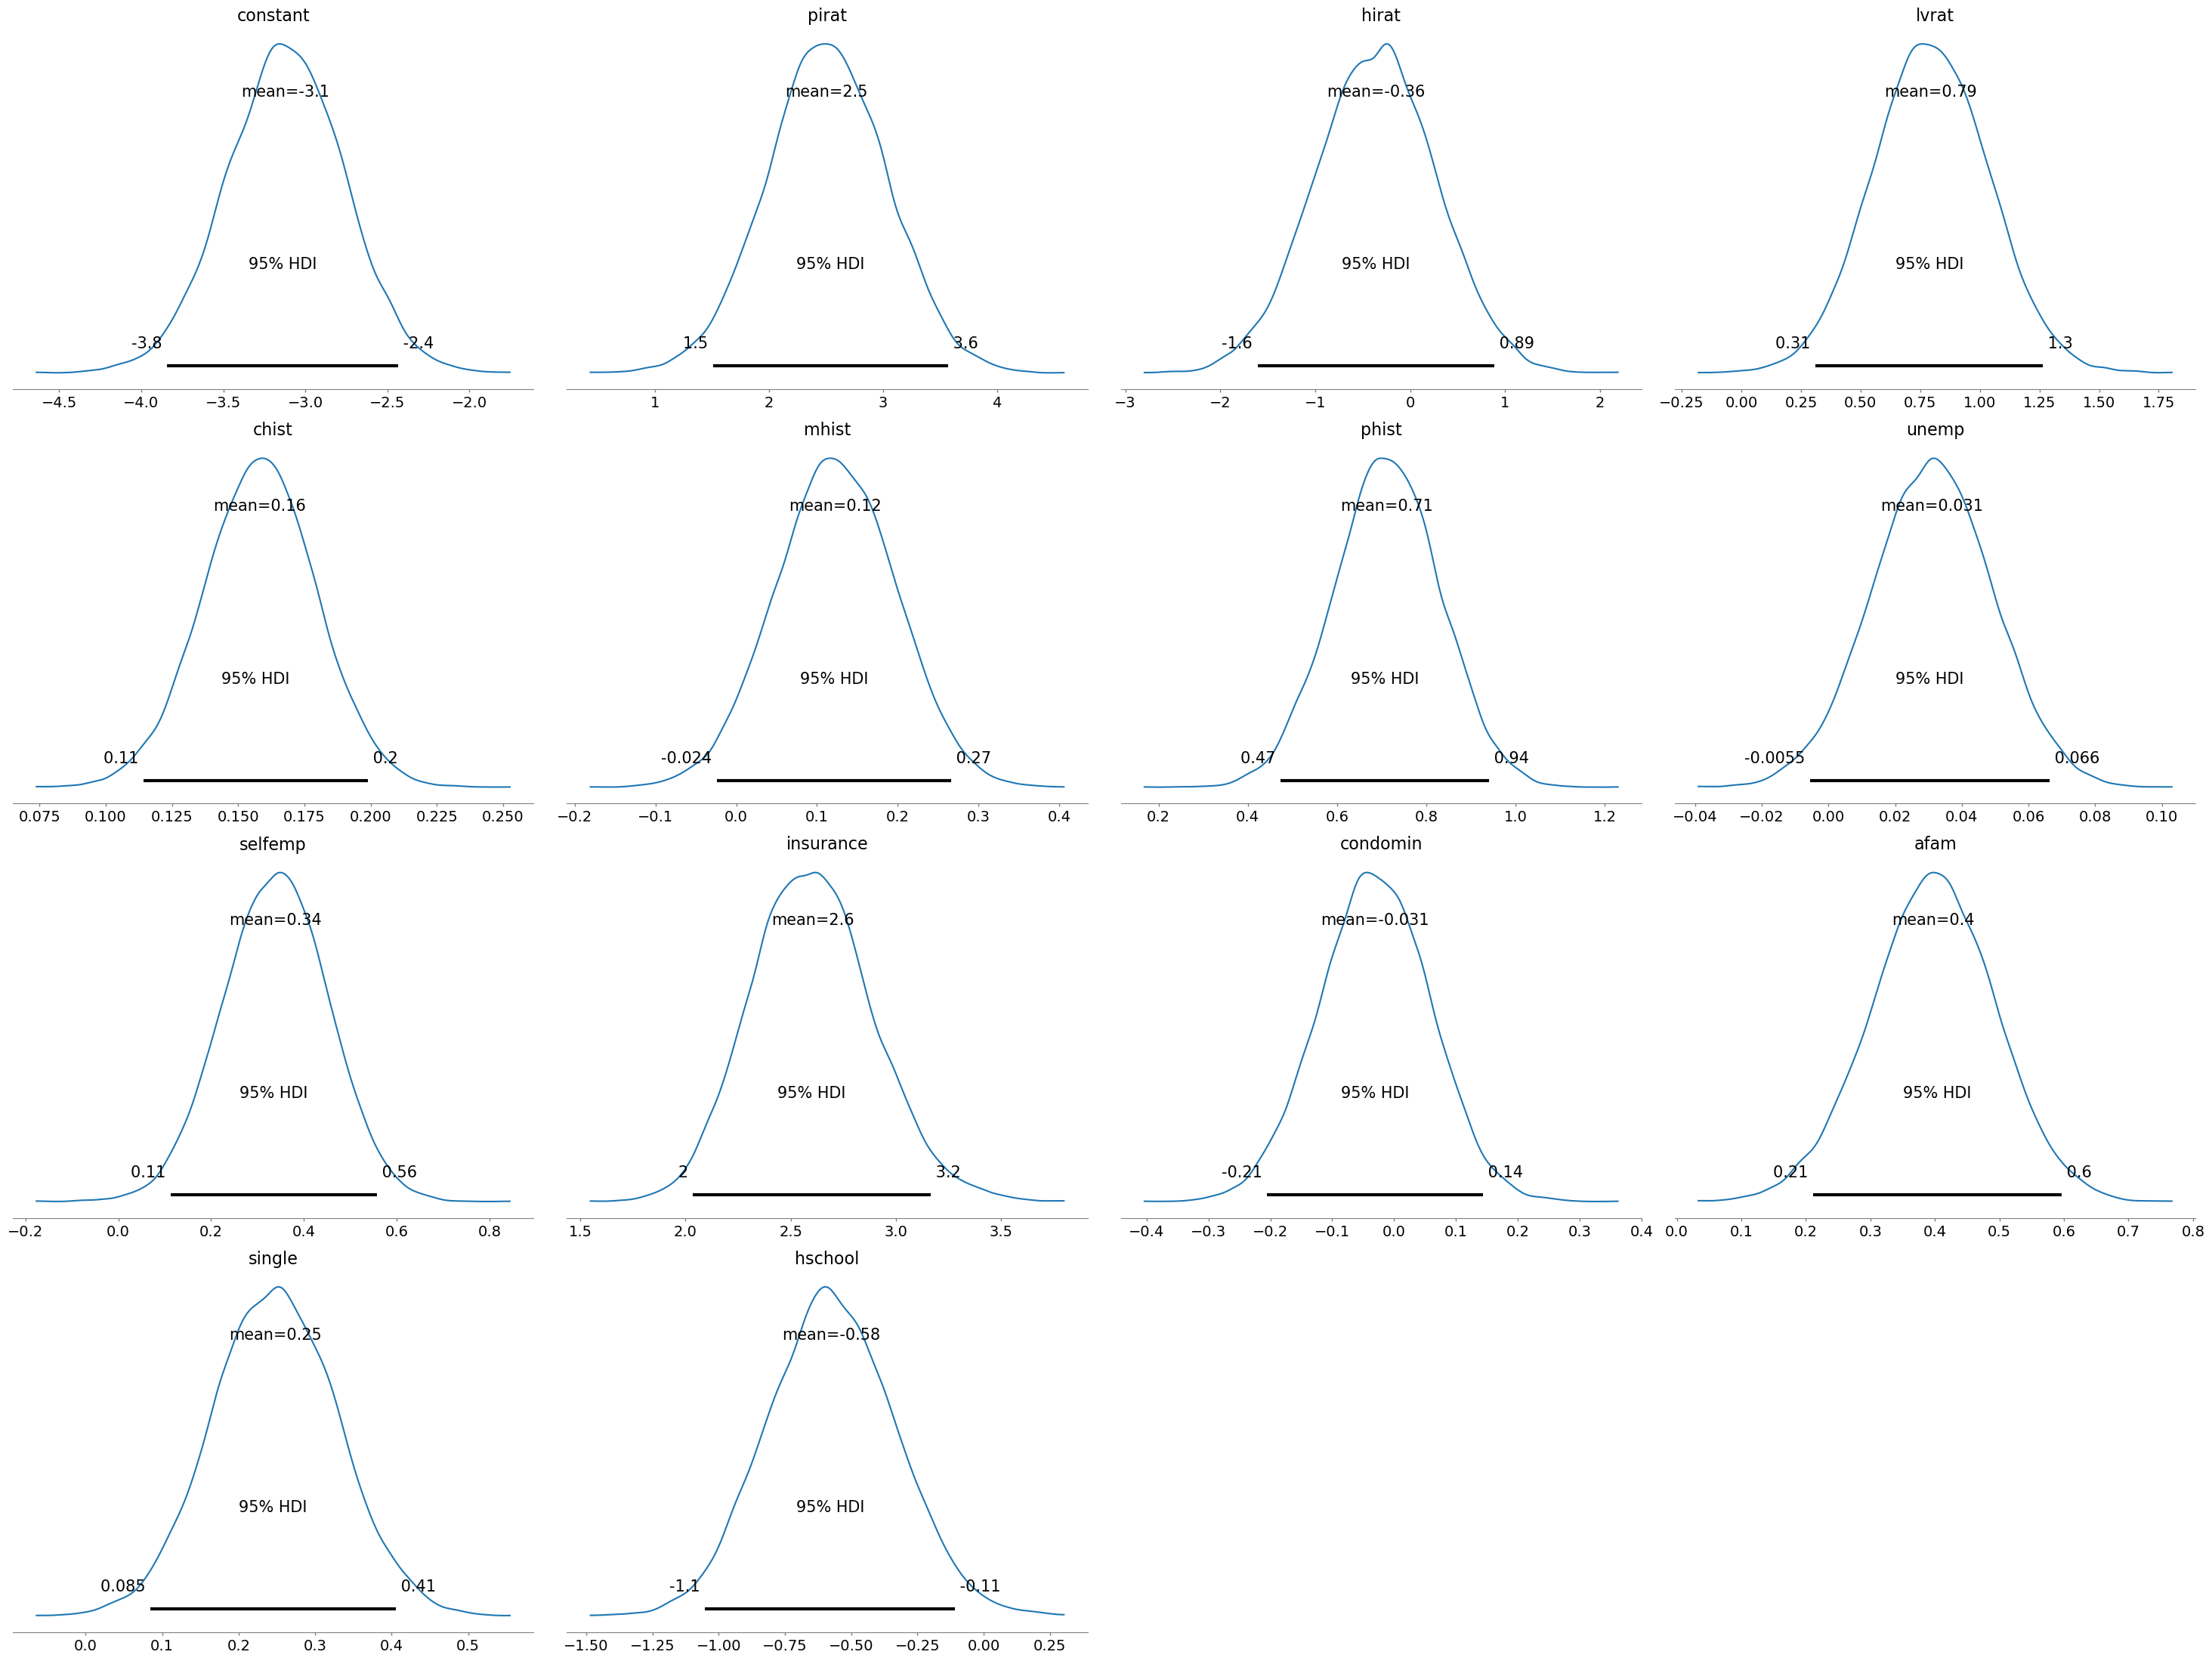

In [14]:
pm.plot_posterior(sim_param_probit, kind='kde', point_estimate='mean', hdi_prob=0.95)
plt.tight_layout()
plt.show()